# Nonlinear deterministic generating functions

Perception in a passive agent using linear deterministic generating functions.

==========================================================================

* **Notebook dependencies**:
    * ...

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from scipy.stats import norm, uniform
from types import SimpleNamespace

mpl.style.use("seaborn-deep")

In this example we show Bayesian inference for a nonlinear generating function in the probabilistic setting. We use the following model and environment:

$$
    \mathscr{E} \triangleq  
    \begin{cases}
        y = g_{\mathscr{E}}(x^*; \theta^*) + \omega_y^*    & \text{Outcome generation} \\
        g_{\mathscr{E}}(x^*; \theta^*) = \beta_0^* + \beta_1^* \psi(x^*) & \text{Generating function} \\
        \psi(x^*) = {x^*}^2 & \text{Nonlinear transform of } x^* \\
        \omega_y^* \sim \mathcal{N}(0, \sigma^2=1) & \text{Observation noise} \\
        \theta^* := \left \{\beta_0^* = 3, \beta_1^* = 2 \right \} & \text{Observation parameters}
    \end{cases}
$$

$$
    \mathcal{M} \triangleq  
    \begin{cases}
        p_{\mu_y, \sigma^2_y}(y \mid x) = \mathcal{N}(y; g_{\mathcal{M}}, \sigma^2_y) & \text{Likelihood} \\
        p_{\mu_y, \sigma^2_y}(x) = \mathcal{N}(x; m_x, s^2_x) & \text{Prior on } x \\
        g_{\mathcal{M}}(x; \theta) = \beta_0 + \beta_1 \psi(x) & \text{Generating function} \\
        \psi(x) = x^2 & \text{Nonlinear transform of} x \\
        \theta := \left \{\beta_0 = 1, \beta_1 = 1\right \}  & \text{Linear parameters} \\
        \phi := \left \{\sigma^2_y = 0.25, m_x = 4, s^2_x = 0.25  \right \} & \text{Other parameters}
    \end{cases}
$$

First we visualize the agent's generating function.


In [38]:
def phi(x_star: float) -> float:
    return x_star ** 2

def generating_function(beta_0_star: float, beta_1_star: float, x_star: float) -> float:
    return beta_1_star * phi(x_star) + beta_0_star

def noise(std: float) -> float:
    return np.random.normal(loc=0, scale=std)

n       = 500                                       # Number of samples
x_range = np.linspace(start=-2.5, stop=2.5, num=n)  # Support of x
y       = np.zeros(500)                             # Initialize empty y array

for idx, x in enumerate(x_range):
    y[idx] = generating_function(beta_0_star=1, beta_1_star=1, x_star=x) + noise(std=0.5)

<Figure size 432x288 with 0 Axes>

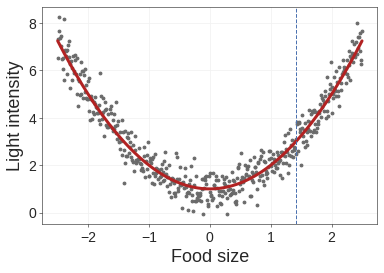

In [39]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Linear generating function
ax.plot(x_range, generating_function(beta_0_star=1, beta_1_star=1, x_star=x_range),
        c="#B22222", linewidth=3)

# Noisy samples
ax.scatter(x_range, y,
        c="#696969", s=8)

ax.axvline(x=np.sqrt(2), linestyle="dashed", linewidth=1)

# Axis labels and styling
ax.set_xlabel("Food size", fontsize=18)
ax.set_ylabel("Light intensity", fontsize=18)
ax.axes.grid(which="major", axis="both", c="#f2f2f2")
plt.setp(ax.spines.values(), color="black", linewidth=0.5)
ax.tick_params(
    labelsize=14,
    axis='both',          
    which='major',      
    bottom=True,
    left=True,
    color="black",
    width=0.5,
    length=3)

The dotted line in the above image indicates a hidden state of $x^* = \sqrt{2} = 1.414...$ which would generate the observation $y=3$. Now we create and agent and environment to capture them in code. The environment is exactly the same as the previous example. The agent differs in the prior which is now Gaussian and the variance of the likelihood and prior which are now no longer close to zero.

In [9]:
class StaticEnvironment:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def noise(self):
        return np.random.normal(loc=0, scale=self.params.y_star_std)
    
    def phi(self, x_star: float) -> float:
        return x_star**2
    
    def generating_function(self, x_star: float) -> float:
        return self.params.beta_1_star * phi(x_star) + self.params.beta_0_star
    
    def generate(self, x_star: float) -> float:
        return self.generating_function(x_star) + self.noise()

In [98]:
class StaticAgent:
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
        self.likelihood = None
        self.prior = None
        
    def phi(self, x: float) -> float:
        return x**2
        
    def generating_function(self):
        return self.params.beta_1 * self.phi(self.params.x_range) + self.params.beta_0
        
    def generative_model(self, y: float):
        self.likelihood = norm.pdf(y, loc=self.generating_function(), scale=self.params.std_y)
        self.prior      = norm.pdf(x_range, loc=self.params.mu_x, scale=self.params.std_x)
        
        # Constrain prior probability
        # self.prior[0:250] = 0
        
        return self.likelihood * self.prior
        
    def infer_state(self, y: float):
        gen_model = self.generative_model(y)
        evidence  = np.sum(gen_model, axis=0)
        posterior = gen_model / evidence
        return posterior

In [99]:
# Environment parameters
env_params = {
    "beta_0_star" : 1,    # Linear parameter intercept
    "beta_1_star" : 1,    # Linear parameter slope
    "y_star_std"  : 1e-5  # Standard deviation of sensory data
}

# Agent parameters
agent_params = {
    "beta_0" : 1,    # Linear parameter intercept
    "beta_1" : 1,    # Linear parameter slope
    "std_y"  : 0.5,  # Likelihood standard deviation
    "mu_x"   : 2,    # Prior mean
    "std_x"  : 0.5,  # Prior standard deviation
    "x_range": np.linspace(start=-2.5, stop=2.5, num=500)
}

In [100]:
# Initialize environment and agent
env       = StaticEnvironment(env_params)
agent     = StaticAgent(agent_params)

# Set true state and generate sensory data
x_star    = np.sqrt(2)
y         = env.generate(x_star)

# Perception: Agent infers belief over hidden state using sensory data
posterior = agent.infer_state(y)

# Get likelihood and prior from agent
likelihood = agent.likelihood
prior = agent.prior

<Figure size 432x288 with 0 Axes>

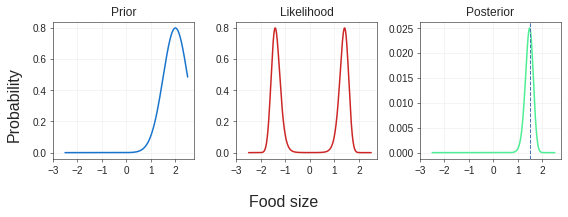

In [101]:
plt.style.use("seaborn-whitegrid")
fig = plt.figure()
fig, axes = plt.subplots(1,3, facecolor=(1,1,1), figsize=(8,3))

# Main plot
axes[0].plot(x_range.tolist(), prior, c="#1874cd")        # Prior
axes[1].plot(x_range.tolist(), likelihood, c="#cd2626")   # Likelihood
axes[2].plot(x_range.tolist(), posterior, c="#4eee94")    # Posterior

# Posterior mode and posterior axis
axes[2].axvline(x=x_range[np.argmax(posterior)], ls="dashed", lw=1)

# Titles
axes[0].set_title("Prior")
axes[1].set_title("Likelihood")
axes[2].set_title("Posterior")

# Axis global labels
fig.supxlabel("Food size", fontsize=16)
fig.supylabel("Probability", fontsize=16)

# Cosmetic changes and axes ranges
for ax in axes:
    ax.xaxis.set_ticks(np.arange(-3, 3, 1))
    ax.axes.grid(which="major", axis="both", c="#f2f2f2")
    plt.setp(ax.spines.values(), color="black", linewidth=0.5)
    ax.tick_params(
        axis='both',          
        which='major',      
        bottom=True,
        left=True,
        color="black",
        width=0.5,
        length=3)
    
fig.tight_layout()

In [102]:
mode = np.round(x_range[np.argmax(posterior)], 3)
print(f"The posterior mode is {mode}. This is the expected or inferred food size, the hidden state estimate, when the observed light intensity is 3")

The posterior mode is 1.478. This is the expected or inferred food size, the hidden state estimate, when the observed light intensity is 3


As we can see, the likelihood contains probabilities centered over both solutions to the inverted model but the prior constraint that a negative food size has a near zero probability bias or constrains the posterior estimate to the positive reals. 